# Spiral arm instability

In [1]:
import os
from IPython.display import Image
import numpy as np
from PIL import Image as Im
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
Distance = 9.3 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)
scale = (Distance*1000*2*np.pi)/(360*60*60.) # kpc/acrsec

In [17]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
Sigma_s_old = np.load('./data/Sigma_s_old.npy')
Sigma_SFR = np.load('./data/Sigma_SFR.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
r_HI_old = np.load('./data/r_HI_old.npy')
vel_HI_old = np.load('./data/vel_HI_old.npy')
velocity_HI = np.load('./data/velocity_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc_corr.npy')
sig_R_min_err = np.load('./data/sig_R_min_err.npy')
sig_R_max_err = np.load('./data/sig_R_max_err.npy')
sigma_s_err = np.load('./data/sigma_s_err.npy')
phi = np.load('./data/phi.npy')
mask_stars =  np.load('./data/mask_stars.npy')

## A single-component model


$$ S = \dfrac{\sigma^2 \kappa^2 + 4 \Omega^2}{\pi G f(\kappa W) Y \kappa^2}$$



$f(\kappa W) = K_0(\kappa W) L_{-1}(\kappa W) + K_1(\kappa W) L_0(\kappa W)$

where $K_i$ and $L_i$ are modified Bessel and Struve functions of order i

$$Y = 1.4 W \Sigma_0$$
$$\sigma = \sigma_{\phi} + c$$
$\sigma_{\phi}$ and $c$ are azimuthal dispersion of turbulent velocities and sound velocity of gas.

### The instability condition issatisfied when min(S(k))<1

## A two-component model


$$ S = \dfrac{1}{\pi G \kappa^2} \left(\dfrac{f(\kappa W_g) Y_g}{\sigma_g^2 \kappa^2 + 4 \Omega_g^2} + \dfrac{f(\kappa W_s) Y_s }{\sigma_s^2 \kappa^2 + 4 \Omega_s^2} \right) ^ {-1}$$



$f(\kappa W) = K_0(\kappa W) L_{-1}(\kappa W) + K_1(\kappa W) L_0(\kappa W)$

where $K_i$ and $L_i$ are modified Bessel and Struve functions of order i

$$Y_{g,s} = 1.4 W_{g,s} \Sigma^0_{g,s}$$
$$\sigma_g = \sigma_{\phi}^g + c$$
$\sigma_{\phi}^g$ and $c$ are azimuthal dispersion of turbulent velocities and sound velocity of gas.

### The instability condition issatisfied when min(S(k))<1

## Газовый диск

Для начала обрежем карту с маской до нужных нам размеров.

In [ ]:
# обрезаем данные
# по сути все как в get_data только без функций
image_file = get_pkg_data_filename('spirals/HI/arms_mask.fits')
image_file = fits.getdata(image_file)
image_data = np.squeeze(image_file)

data = fits.getdata('./data/NGC_3627_NA_MOM0_THINGS.FITS')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC_3627_NA_MOM0_THINGS.FITS', naxis = 2)
cposition = SkyCoord('{} {}'.format(data_WCS.wcs.crval[0], data_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')

size = [380,140] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)    
image_data = Cutout2D(image_data, cposition, size_, wcs=data_WCS, mode='partial', fill_value=0.)


# теперь делаем их нужной размерности
shape = [190,70]
first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((shape[0], shape[1]))
    
grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data.data[int(spix[1])][int(spix[0])])
    
new_data = np.array(new_data).reshape(190,70)   

mask_gas = new_data[0:-34,0:-4]

Теперь вызволим из таблиц необходимые мне данные

In [ ]:
# угол закрутки
def get_pitch_data(color=None):
    pitch = []
        
    with open('spirals/HI/PGC0000_arm_tangents.reg', 'r') as file:
        for l in file.readlines():
            color_ = l[l.index('color=')+6:l.index('pitch=')].replace('  ', '')
            
            if color_ == color:
                pitch.append(float(l[l.index('pitch=')+6:]))
                
    return pitch            
                
# плотность потока в пике
def get_peak_density_data(filename=None):
    peak_flux = []
    
    with open(filename, 'r') as file
        lines = file.readlines()
        for l in lines[1:]:
            param = l.split()
            peak_flux = float(param[8])
            peak_density.append(280 * cosi * peak_flux)  
    
    return peak_density

# полуширина в гауссиане
def get_half_width_data(filename=None):
    width_left = []
    width_right = []
    coeff =     #!!!! нужно ещё раз пересчитать масштабный коэффициент
    with open(filename, 'r') as file
        lines = file.readlines()
        for l in lines[1:]:
            param = l.split()
            width_left =  float(param[5])
            width_right = float(param[7])
            width.append(coeff * (width_right + width_left) * 0.5)
            
    return width


Перейдем к самому критерию

### Поиccледум функцию $S(\kappa)$

In [58]:
 from scipy.special import j0,j1,struve
    

In [59]:
f = lambda y: j0(y) * struve(-1,y) + j1(y) * struve(0,y)
S = lambda x: (sigma**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W) * Y * x**2)

In [60]:
W = 0.5
sigma = 5
Omega = 50
G = 4.32
Y = 1.4 * W * 8


In [61]:
k = np.linspace(1,100,1000)
Crit = S(k)

(0, 40)

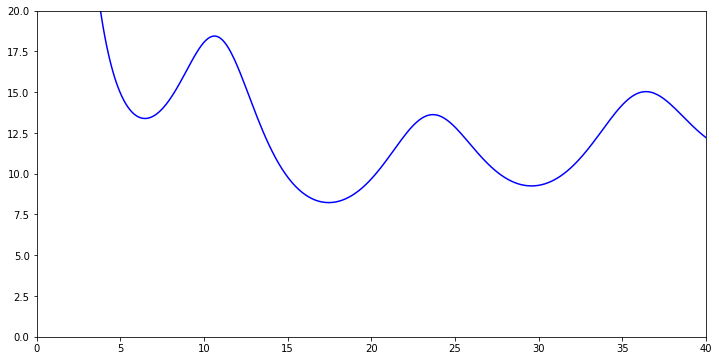

In [62]:
plt.figure(figsize=[12, 6])
plt.plot(k,Crit,'blue')
plt.ylim(0,20)
plt.xlim(0,40)

In [ ]:
pitch = get_pitch_data(color=green)
width = get_half_width_data(filename='spirals/HI/arm_params_green.dat')
peak_density = get_peak_density_data(filename='spirals/HI/arm_params_green.dat')

In [ ]:
k = np.linspace(1,50,100)
inst_param = np.zeros(dist_kpc.shape)
phi_border = 
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        for k in range(31):
            if (mask_gas[i][j]!=1.) & (phi_borger[k]<=phi[i][j]<phi_border[k+1]) & (j>30):
                sigma = sigma_s[i][j]/1000.
                Omega = 50
                W = width[k]#/np.cos(pitch[k])
                Y = 1.44 * width[k] * peak_density[k]
                S = (sigma**2 * k**2 + 4 * Omega**2) / (np.pi * G * f(k*W) * Y * k**2)
                inst_param[i][j] = np.min(S) 

## Звездный диск

In [67]:
# Маску для звездного диска я уже обрезала ниже

In [68]:
# угол закрутки
def get_pitch_data(color=None):
    pitch = []
        
    with open('spirals/Sigma_S/PGC0000_arm_tangents.reg', 'r') as file:
        for l in file.readlines():
            color_ = l[l.index('color=')+6:l.index('pitch=')].replace('  ', '')
                        
            if color_ == color:
                pitch.append(float(l[l.index('pitch=')+6:]))
                
    return pitch            
                
# плотность потока в пике
def get_peak_density_data(filename=None):
    peak_density = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        for l in lines[1:]:
            param = l.split()
            peak_flux = float(param[8])
            peak_density.append(280 * cosi * peak_flux)
    
    return peak_density

# полуширина в гауссиане
def get_half_width_data(filename=None):
    width=[]
    coeff = 0.172    #!!!! нужно ещё раз пересчитать масштабный коэффициент
    with open(filename, 'r') as file:
        lines = file.readlines()
        for l in lines[1:]:
            param = l.split()
            width_left =  float(param[5])
            width_right = float(param[7])
            width.append(coeff * (width_right + width_left) * 0.5)
   
    
    return width


In [63]:
from scipy.special import j0,j1,struve
f = lambda y: j0(y) * struve(-1,y) + j1(y) * struve(0,y)
S = lambda x: (sigma_S**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_s) * Y_s * x**2)

In [64]:
S1 = lambda x: 1/np.pi*G*x**2 * (  (Y_g * f(x*W_g))/(sigma_g**2*x**2 + 4*Omega**2) + (Y_s * f(x*W_s))/(sigma_s**2*x**2 + 4*Omega**2) )

In [65]:
W_g = 0.5
W_s = 0.2
sigma_g = 5
sigma_S = 50
Omega = 70
G = 4.32
Y_g = 1.4 * W_g * 8
Y_s = 1.4 * W_s * 3000

In [66]:
k = np.linspace(1,100,1000)
Crit = S1(k)

ValueError: operands could not be broadcast together with shapes (156,66) (1000,) 

(0, 100)

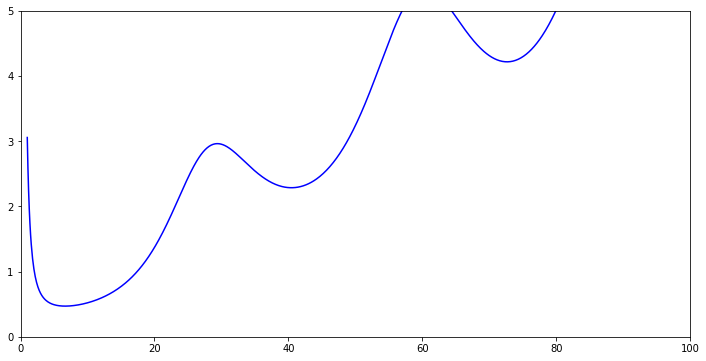

In [13]:
plt.figure(figsize=[12, 6])
plt.plot(k,Crit,'blue')
plt.ylim(0,5)
plt.xlim(0,100)

In [69]:
pitch_green = get_pitch_data(color='green')
width_green = get_half_width_data(filename='spirals/Sigma_S/arm_params_green.dat')
peak_density_green = get_peak_density_data(filename='spirals/Sigma_S/arm_params_green.dat')

pitch_red = get_pitch_data(color='red')
width_red = get_half_width_data(filename='spirals/Sigma_S/arm_params_red.dat')
peak_density_red = get_peak_density_data(filename='spirals/Sigma_S/arm_params_red.dat')

In [70]:
phi_border_green = np.linspace(26,177,53)
phi_border_red = np.linspace(46,141,27)

In [81]:
x = np.linspace(1,50,100)
inst_param = np.zeros(dist_kpc.shape)
inst_param[:,:] = np.nan

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        for k in range(52):
            if (mask_stars[i][j]!=0.) & (phi_border_green[k]<=phi[i][j]<phi_border_green[k+1]) & (j>25):
                sigma_gr = sigma_s[i][j]*0.6
                Omega = 50.
                W_gr = width_green[k]/np.cos(pitch_green[k])
                Y_gr = 1.44 * W_gr * peak_density_green[k]
                S_gr = (sigma_gr**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_gr) * Y_gr * x**2)
                inst_param[i][j] = np.min(S_gr)
                
        for l in range(26):
            if (mask_stars[i][j]!=0.) & (phi_border_red[l]<=phi[i][j]<phi_border_red[l+1]) & (j<25):
                sigma_r = sigma_s[i][j]*0.6
                Omega = 50.
                W_r = width_red[l]/np.cos(pitch_red[l])
                Y_r = 1.44 * W_r * peak_density_red[l]
                S_r = (sigma_r**2 * x**2 + 4 * Omega**2) / (np.pi * G * f(x*W_r) * Y_r * x**2)
                inst_param[i][j] = np.min(S_r)    

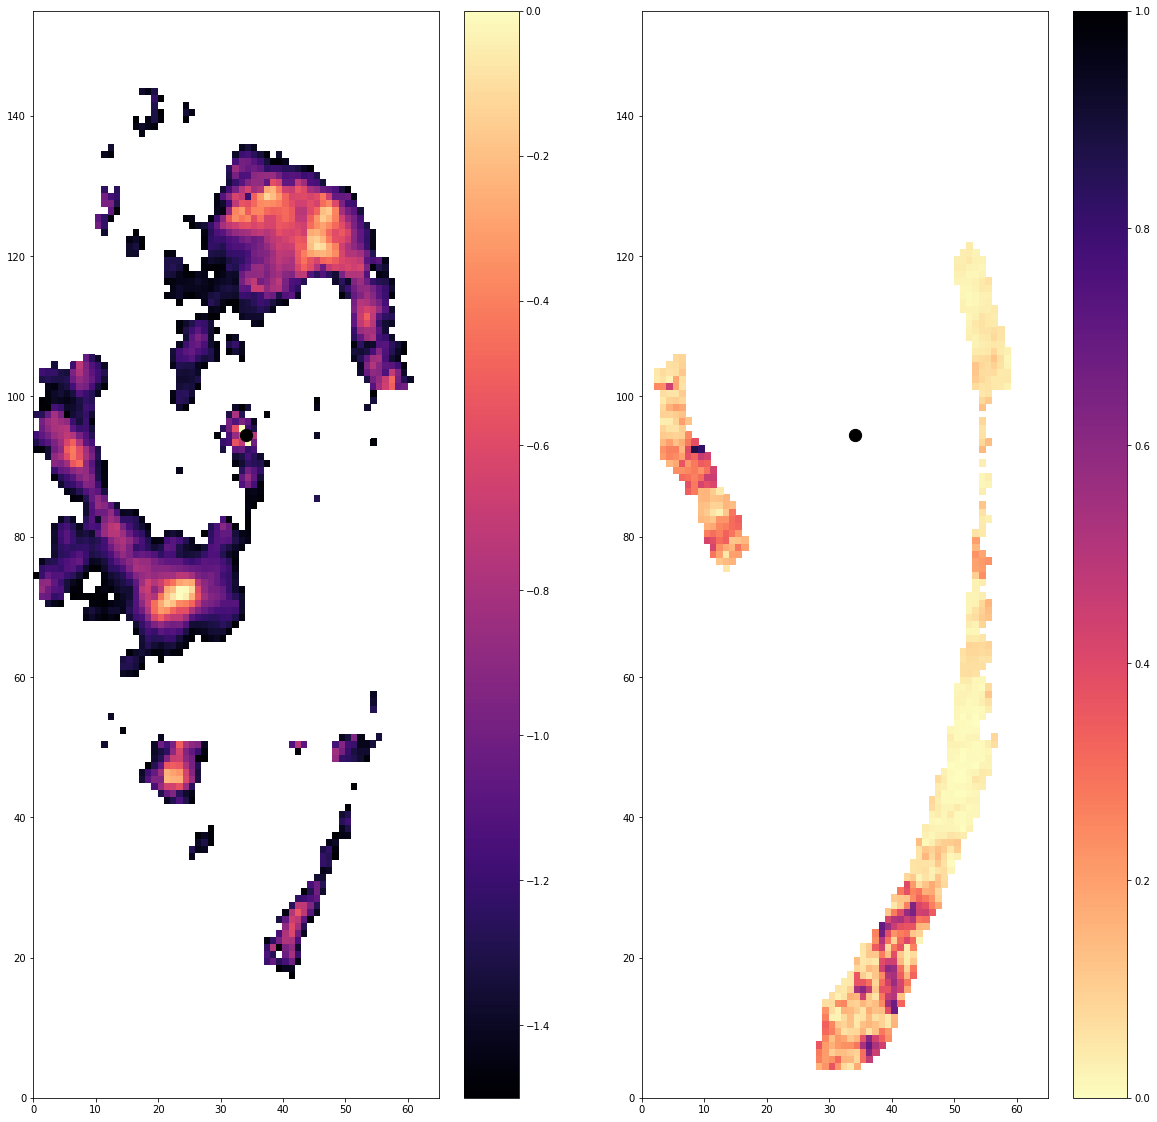

In [83]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, np.log10(Sigma_SFR), cmap='magma')
quadmesh.set_clim(vmin=-1.5, vmax=0)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,inst_param, cmap='magma_r')
quadmesh.set_clim(vmin=0., vmax=1.)
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

Попробуем обрезать маску для звездного диска

In [29]:
image_file = get_pkg_data_filename('spirals/tst.fits')
image_data = fits.getdata(image_file, ext=0)
image_file_ = get_pkg_data_filename('spirals/arms.fits')
image_data_ = fits.getdata(image_file_, ext=0)

data_WCS = WCS('spirals/tst.fits', naxis = 2)
print(data_WCS)

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 267  533


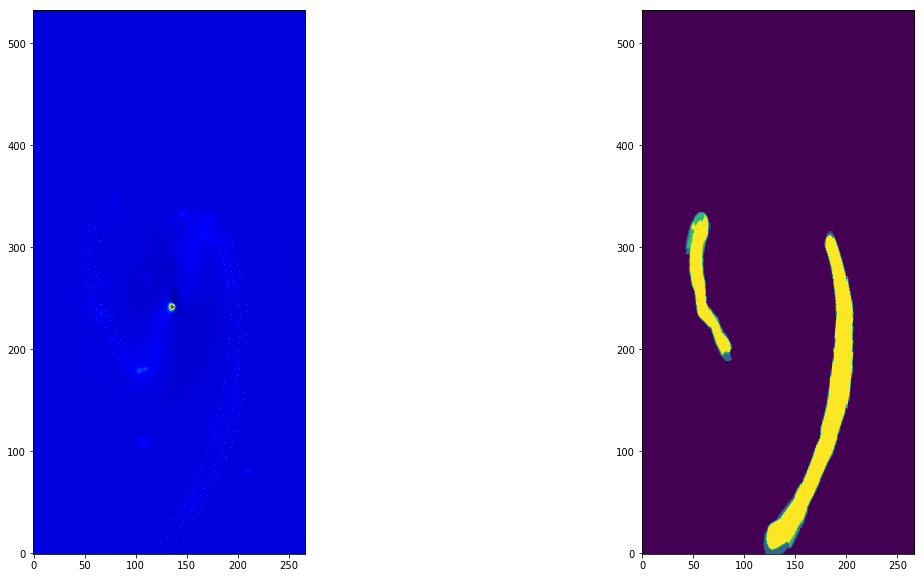

In [30]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(121)

pic = ax.imshow(image_data,cmap='jet',origin='lower')

ax_ = plt.subplot(122)

ax_.imshow(image_data_,origin='lower')

In [31]:
data = fits.getdata('./data/NGC3627.phot.1_nonan.fits')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC3627.phot.1_nonan.fits', naxis = 2)
cposition = SkyCoord('{} {}'.format(data_WCS.wcs.crval[0], data_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')

size = [400,200] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)

first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

X, Y = np.meshgrid(np.arange(0, 100, 1), np.arange(0, 200, 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((200, 100))

image_data = np.squeeze(image_data)

grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data[int(spix[1])][int(spix[0])])
    
new_data = np.array(new_data).reshape(200,100) 


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


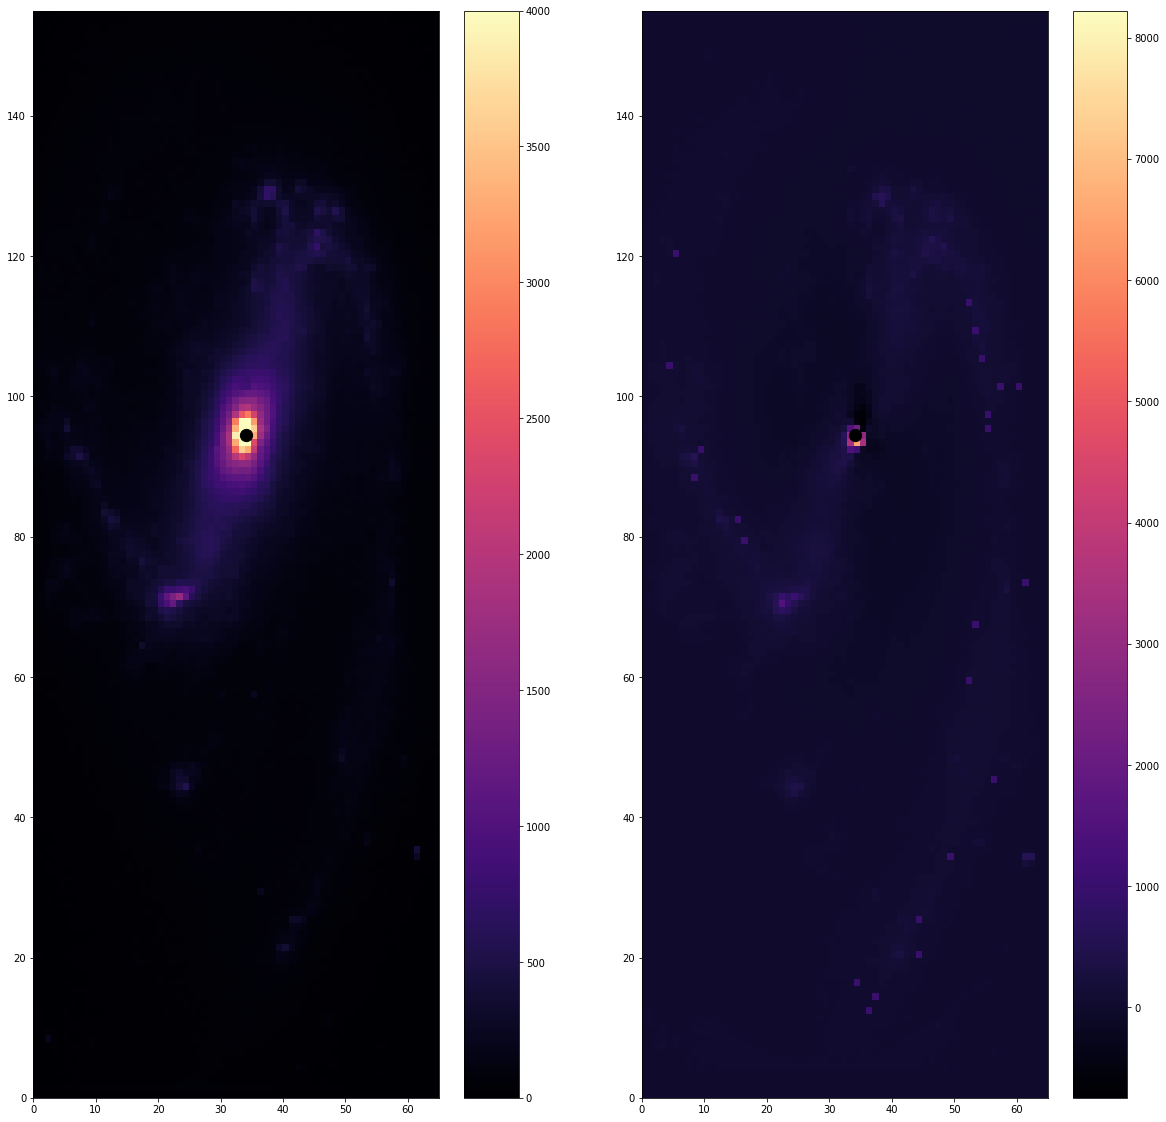

In [32]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,100,1), np.arange(0.,200,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=4000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

plt.subplot(1,2,2)
new_data_ = new_data[22:-22,29:-5]
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )


теперь проделаем то же самое с маской

In [33]:
data = fits.getdata('./data/NGC3627.phot.1_nonan.fits')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC3627.phot.1_nonan.fits', naxis = 2)
cposition = SkyCoord('{} {}'.format(data_WCS.wcs.crval[0], data_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')

size = [400,200] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)

first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

X, Y = np.meshgrid(np.arange(0, 100, 1), np.arange(0, 200, 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((200, 100))

image_data_ = np.squeeze(image_data_)

grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(image_data_[int(spix[1])][int(spix[0])])
    
new_data = np.array(new_data).reshape(200,100)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


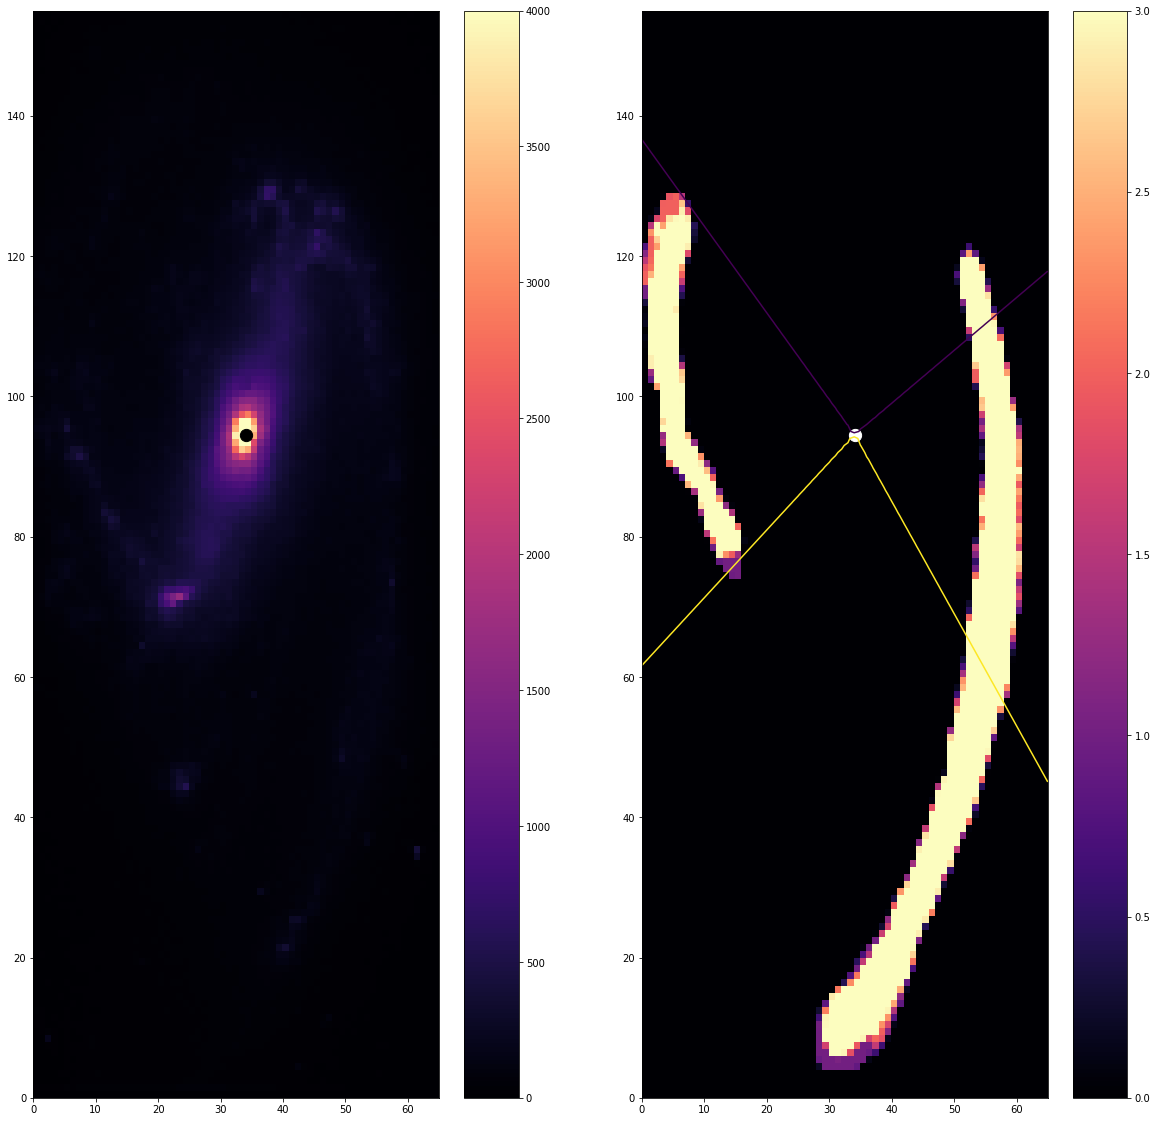

In [38]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,100,1), np.arange(0.,200,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=4000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='black' )

plt.subplot(1,2,2)
new_data_ = new_data[22:-22,29:-5]
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )
CS = plt.contour(X, Y, phi, levels=[46., 141.], aspect='auto')

In [27]:
mask_stars = new_data[22:-22,29:-5]
np.save('./data/mask_stars.npy', mask_stars)

Теперь попробуем понять какие позиционные углы конца и начала спиралей

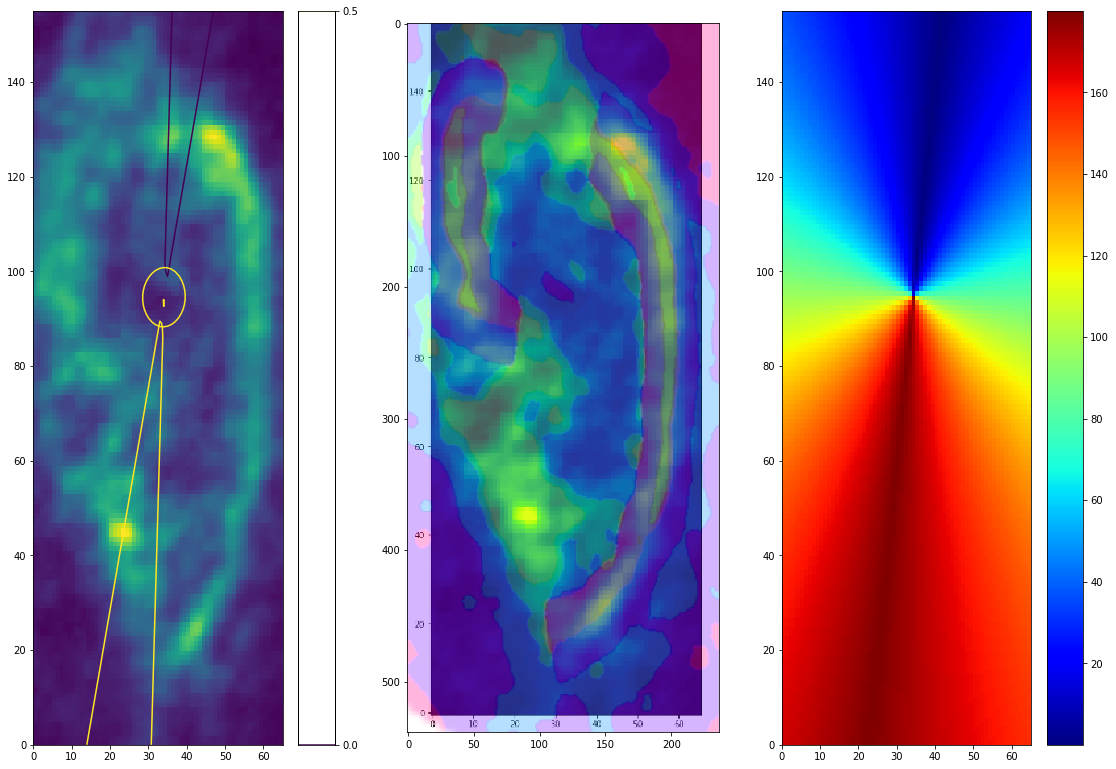

In [14]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[19, 13.5])
plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_HI)
CS = plt.contour(X, Y, phi, levels=[5., 175.], aspect='auto')
CS = plt.contour(X, Y, dist_kpc, levels=[0, 0.5], aspect='auto')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(Im.open('./images/Sigma_HI.png'))
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(X, Y, phi, cmap='jet')
plt.colorbar()
plt.show()

У нас есть 30 срезов, значит, на каждый из них приходится по 5.6 градусов.
Также нужно перевести из данного масштаба (на 1 пиксель 0.4 пк). После уменьшения разрешения получаем масштаб 0.5 pc/pix. На нашей карте в 1 пикселе 85.9 пк. Следовательно для перевода нужно умножать на 172. 